In [1]:
import pandas as pd
import numpy as np
import replicaEVSE.load_curve as sim
import replicaEVSE.datautils as simdu
import os
import joblib
import dask.dataframe as dd
from tqdm import tqdm
from datetime import datetime, timedelta

%reload_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)

datadir = '../../data/'
mode = 'PRIVATE_AUTO'
test = False

# Dev the precompute of stop time. 

 - it must be run on a single person on a single day. can use groupby or use forloops
   - these are equivalent but the groupby is faster. 
   - there is a faster way to do with `df.shift()` but untested. 
 - there are negative and positive days. 
    - negative days are due to some glitch in replica where a trip ends after the next one begins. 
    - positive days are due to a trip ending past midnight. could just subtract a day from these  


In [2]:
# read in data and filter for mode
merged_df = pd.read_parquet(os.path.join(datadir, 'wa_pop_and_trips_sorted_county.parquet'))

example of a trip ending after the next trip is supposed to start. 

In [3]:
cols = ['person_id', 'mode', 'weekday', 'start_time', 'end_time',]
merged_df[merged_df['person_id'] == '10235640618012933224'][cols]

,person_id,mode,weekday,start_time,end_time
14758,10235640618012933224,PRIVATE_AUTO,thursday,0 days 03:40:54,0 days 05:01:52
14759,10235640618012933224,PRIVATE_AUTO,thursday,0 days 04:05:17,0 days 04:22:16
14760,10235640618012933224,CARPOOL,saturday,0 days 08:21:38,0 days 08:31:54
14761,10235640618012933224,PRIVATE_AUTO,saturday,0 days 08:43:48,0 days 08:55:42
14762,10235640618012933224,PRIVATE_AUTO,thursday,0 days 14:10:24,0 days 15:25:23


run on a subset of the data

In [4]:
df = merged_df.loc[merged_df['mode'] == mode]
df = df.head(100000)


In [14]:
groups = df.sort_values(by=['person_id', 'weekday', 'start_time']).groupby(['person_id', 'weekday'])
outlist = joblib.Parallel(verbose=1, n_jobs=4)(joblib.delayed(simdu.calculate_stop_duration)(group) for name, group in groups)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 123 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 30290 tasks      | elapsed:   12.4s
[Parallel(n_jobs=4)]: Done 31253 out of 31253 | elapsed:   12.6s finished


In [10]:
groupby_df_stop_dur = pd.concat(outlist).reset_index(drop=True)

In [12]:
groupby_df_stop_dur[groupby_df_stop_dur['weekday'] == 'thursday']

,activity_id,person_id,mode,travel_purpose,previous_activity_type,start_time,end_time,distance_miles,vehicle_type,origin_bgrp,origin_bgrp_lat,origin_bgrp_lng,destination_bgrp,destination_bgrp_lat,destination_bgrp_lng,origin_land_use_l1,origin_land_use_l2,origin_building_use_l1,origin_building_use_l2,destination_land_use_l1,destination_land_use_l2,destination_building_use_l1,destination_building_use_l2,origin_lat,origin_lng,destination_lat,destination_lng,weekday,household_id,BLOCKGROUP,BLOCKGROUP_work,BLOCKGROUP_school,TRACT,TRACT_work,TRACT_school,age_group,age,sex,race,ethnicity,individual_income_group,individual_income,employment,education,school_grade_attending,industry,household_role,subfamily_number,subfamily_relationship,commute_mode,tenure,migration,household_size,household_income_group,household_income,family_structure,vehicles,building_type,resident_type,language,lat,lng,lat_work,lng_work,lat_school,lng_school,wfh,charge_type,destination_county,stop_duration
2,18336634547462657450,10000002909730821040,PRIVATE_AUTO,SOCIAL,HOME,0 days 08:20:42,0 days 08:39:00,2.897196,nan,530250111002,47.098457,-119.319023,530250111003,47.117839,-119.303234,residential,single_family,residential,single_family,residential,single_family,residential,single_family,47.085370,-119.319090,47.118737,-119.298334,thursday,17571687911180552742,530250111002,530250110001,nan,53025011100,53025011000,nan,35_64,64.0,M,white,hispanic_or_latino,100000_plus,103145.0,employed,some_college,not_attending_school,naics53,spouse,0,nan,driving,owner,same_house,2_person,125000_plus,211447.0,married_couple,3_plus,single_family,core,english,47.085370,-119.319090,47.132725,-119.213000,NaN,NaN,worked_in_person,PUBLIC,"Grant County, WA",0 days 00:33:45
3,1694659094182985471,10000002909730821040,PRIVATE_AUTO,HOME,SOCIAL,0 days 09:12:45,0 days 09:19:56,2.867602,nan,530250111003,47.117839,-119.303234,530250111002,47.098457,-119.319023,residential,single_family,residential,single_family,residential,single_family,residential,single_family,47.118737,-119.298334,47.085370,-119.319090,thursday,17571687911180552742,530250111002,530250110001,nan,53025011100,53025011000,nan,35_64,64.0,M,white,hispanic_or_latino,100000_plus,103145.0,employed,some_college,not_attending_school,naics53,spouse,0,nan,driving,owner,same_house,2_person,125000_plus,211447.0,married_couple,3_plus,single_family,core,english,47.085370,-119.319090,47.132725,-119.213000,NaN,NaN,worked_in_person,HOME,"Grant County, WA",0 days 04:09:34
4,1649672869607162870,10000002909730821040,PRIVATE_AUTO,SHOP,HOME,0 days 13:29:30,0 days 13:39:45,4.561219,nan,530250111002,47.098457,-119.319023,530250110002,47.125725,-119.262745,residential,single_family,residential,single_family,commercial,retail,commercial,office,47.085370,-119.319090,47.129326,-119.268442,thursday,17571687911180552742,530250111002,530250110001,nan,53025011100,53025011000,nan,35_64,64.0,M,white,hispanic_or_latino,100000_plus,103145.0,employed,some_college,not_attending_school,naics53,spouse,0,nan,driving,owner,same_house,2_person,125000_plus,211447.0,married_couple,3_plus,single_family,core,english,47.085370,-119.319090,47.132725,-119.213000,NaN,NaN,worked_in_person,PUBLIC,"Grant County, WA",0 days 00:58:40
5,8960299674610935725,10000002909730821040,PRIVATE_AUTO,HOME,SHOP,0 days 14:38:25,0 days 14:48:33,4.682996,nan,530250110002,47.125725,-119.262745,530250111002,47.098457,-119.319023,commercial,retail,commercial,office,residential,single_family,residential,single_family,47.129326,-119.268442,47.085370,-119.319090,thursday,17571687911180552742,530250111002,530250110001,nan,53025011100,53025011000,nan,35_64,64.0,M,white,hispanic_or_latino,100000_plus,103145.0,employed,some_college,not_attending_school,naics53,spouse,0,nan,driving,owner,same_house,2_person,125000_plus,211447.0,married_couple,3_plus,single_family,core,english,47.085370,-119.319090,47.132725,-119.213000,NaN,NaN,worked_in_person,HOME,"Grant County, WA",0 days 01:07:11
6,7848053157468418840,100000

In [8]:
groupby_df_stop_dur.stop_duration.min(), groupby_df_stop_dur.stop_duration.max()

(Timedelta('-1 days +20:06:57'), Timedelta('1 days 23:25:04'))

# there are cases where the beginning of one trip starts before the previous trip ends.

 - This is how we get negative values. 
 - there are only 10 cases per 5800

example of negative stop_duration

In [9]:
groupby_df_stop_dur[(groupby_df_stop_dur['person_id'] == '10235640618012933224') & (groupby_df_stop_dur['weekday'] == 'thursday')][['person_id', 'weekday', 'start_time', 'end_time', 'stop_duration']]

,person_id,weekday,start_time,end_time,stop_duration
7634,10235640618012933224,thursday,0 days 03:40:54,0 days 05:01:52,-1 days +23:03:25
7635,10235640618012933224,thursday,0 days 04:05:17,0 days 04:22:16,0 days 09:48:08
7636,10235640618012933224,thursday,0 days 14:10:24,0 days 15:25:23,0 days 12:15:31


In [17]:
groupby_df_stop_dur[(groupby_df_stop_dur['stop_duration'] < pd.Timedelta('0 days 00:00:00'))][cols + ['stop_duration']].shape

(108, 6)

another example with more than one of these negative trips. 

In [10]:
groupby_df_stop_dur[(groupby_df_stop_dur['person_id'] == '10233786896218699845') & (groupby_df_stop_dur['weekday'] == 'thursday')][cols + ['stop_duration']]

,person_id,mode,weekday,start_time,end_time,stop_duration
4561,10233786896218699845,PRIVATE_AUTO,thursday,0 days 05:24:37,0 days 05:53:19,0 days 00:06:29
4562,10233786896218699845,PRIVATE_AUTO,thursday,0 days 05:59:48,0 days 06:33:51,0 days 01:07:18
4563,10233786896218699845,PRIVATE_AUTO,thursday,0 days 07:41:09,0 days 08:21:37,0 days 00:20:40
4564,10233786896218699845,PRIVATE_AUTO,thursday,0 days 08:42:17,0 days 11:42:29,0 days 00:04:56
4565,10233786896218699845,PRIVATE_AUTO,thursday,0 days 11:47:25,0 days 11:53:25,0 days 00:52:32
4566,10233786896218699845,PRIVATE_AUTO,thursday,0 days 12:45:57,0 days 12:49:45,0 days 00:41:03
4567,10233786896218699845,PRIVATE_AUTO,thursday,0 days 13:30:48,0 days 13:59:50,0 days 00:13:00
4568,10233786896218699845,PRIVATE_AUTO,thursday,0 days 14:12:50,0 days 14:43:28,-1 days +23:57:26
4569,10233786896218699845,PRIVATE_AUTO,thursday,0 days 14:40:54,0 days 15:13:27,-1 days +23:39:46
4570,10233786896218699845,PRIVATE_AUTO,thursday,0 days 14:53:13,0 days 15:22:45,0 days 14:01:52


drop the trips with negative days. these are a small percentage (<1%)

In [19]:
no_negs = groupby_df_stop_dur[(groupby_df_stop_dur['stop_duration'] > pd.Timedelta('0 days 00:00:00'))]

# what about positive trips?

subtract a day from them

In [27]:
extra_days = no_negs[no_negs['stop_duration'] > pd.Timedelta('1 days 00:00:00')][cols + ['stop_duration']]

In [28]:
no_negs[no_negs['person_id'] == '10000052964870237790'][cols + ['stop_duration']]

,person_id,mode,weekday,start_time,end_time,stop_duration
98,10000052964870237790,PRIVATE_AUTO,saturday,0 days 20:32:05,0 days 21:29:39,0 days 00:15:52
99,10000052964870237790,PRIVATE_AUTO,saturday,0 days 21:45:31,0 days 21:50:19,0 days 00:16:36
100,10000052964870237790,PRIVATE_AUTO,saturday,0 days 22:06:55,0 days 22:08:47,0 days 00:37:34
101,10000052964870237790,PRIVATE_AUTO,saturday,0 days 22:46:21,0 days 23:05:17,0 days 00:16:52
102,10000052964870237790,PRIVATE_AUTO,saturday,0 days 23:22:09,0 days 00:10:42,1 days 20:21:23
103,10000052964870237790,PRIVATE_AUTO,thursday,0 days 15:07:38,0 days 15:33:13,0 days 04:18:33
104,10000052964870237790,PRIVATE_AUTO,thursday,0 days 19:51:46,0 days 20:15:08,0 days 01:53:21
105,10000052964870237790,PRIVATE_AUTO,thursday,0 days 22:08:29,0 days 22:49:37,0 days 00:04:51
106,10000052964870237790,PRIVATE_AUTO,thursday,0 days 22:54:28,0 days 23:35:35,0 days 15:32:03


In [32]:
cleaned_df = no_negs.copy()
cond = cleaned_df['stop_duration'] > pd.Timedelta('1 days 00:00:00')
out = cleaned_df.mask(cond, cleaned_df['stop_duration'] - pd.Timedelta('1 days 00:00:00'), axis=0)

In [26]:
cleaned_df[cleaned_df['person_id'] == '10000052964870237790'][cols + ['stop_duration']]

,person_id,mode,weekday,start_time,end_time,stop_duration
102,10000052964870237790,PRIVATE_AUTO,saturday,0 days 23:22:09,0 days 00:10:42,0 days 20:21:23


In [34]:
# Subtract one day from values greater than one day
one_day = pd.Timedelta(days=1)
sdf = groupby_df_stop_dur.copy()
sdf.loc[sdf['stop_duration'] > one_day, 'stop_duration'] -= one_day

In [36]:
sdf[sdf['person_id'] == '10000052964870237790'][cols + ['stop_duration']]

,person_id,mode,weekday,start_time,end_time,stop_duration
98,10000052964870237790,PRIVATE_AUTO,saturday,0 days 20:32:05,0 days 21:29:39,0 days 00:15:52
99,10000052964870237790,PRIVATE_AUTO,saturday,0 days 21:45:31,0 days 21:50:19,0 days 00:16:36
100,10000052964870237790,PRIVATE_AUTO,saturday,0 days 22:06:55,0 days 22:08:47,0 days 00:37:34
101,10000052964870237790,PRIVATE_AUTO,saturday,0 days 22:46:21,0 days 23:05:17,0 days 00:16:52
102,10000052964870237790,PRIVATE_AUTO,saturday,0 days 23:22:09,0 days 00:10:42,0 days 20:21:23
103,10000052964870237790,PRIVATE_AUTO,thursday,0 days 15:07:38,0 days 15:33:13,0 days 04:18:33
104,10000052964870237790,PRIVATE_AUTO,thursday,0 days 19:51:46,0 days 20:15:08,0 days 01:53:21
105,10000052964870237790,PRIVATE_AUTO,thursday,0 days 22:08:29,0 days 22:49:37,0 days 00:04:51
106,10000052964870237790,PRIVATE_AUTO,thursday,0 days 22:54:28,0 days 23:35:35,0 days 15:32:03


In [55]:
df = pd.read_parquet(os.path.join(datadir, 'wa_ldv_trips_with_county_and_dwell_time.parquet'))

In [38]:
df[df['person_id'] == '10000052964870237790'][cols + ['stop_duration']]

,person_id,mode,weekday,start_time,end_time,stop_duration
98,10000052964870237790,PRIVATE_AUTO,saturday,0 days 20:32:05,0 days 21:29:39,0 days 00:15:52
99,10000052964870237790,PRIVATE_AUTO,saturday,0 days 21:45:31,0 days 21:50:19,0 days 00:16:36
100,10000052964870237790,PRIVATE_AUTO,saturday,0 days 22:06:55,0 days 22:08:47,0 days 00:37:34
101,10000052964870237790,PRIVATE_AUTO,saturday,0 days 22:46:21,0 days 23:05:17,0 days 00:16:52
102,10000052964870237790,PRIVATE_AUTO,saturday,0 days 23:22:09,0 days 00:10:42,1 days 20:21:23
103,10000052964870237790,PRIVATE_AUTO,thursday,0 days 15:07:38,0 days 15:33:13,0 days 04:18:33
104,10000052964870237790,PRIVATE_AUTO,thursday,0 days 19:51:46,0 days 20:15:08,0 days 01:53:21
105,10000052964870237790,PRIVATE_AUTO,thursday,0 days 22:08:29,0 days 22:49:37,0 days 00:04:51
106,10000052964870237790,PRIVATE_AUTO,thursday,0 days 22:54:28,0 days 23:35:35,0 days 15:32:03


In [58]:
df.shape

(27124460, 70)

In [59]:
# Subtract one day from values greater than one day
one_day = pd.Timedelta(days=1)
df.loc[df['stop_duration'] > one_day, 'stop_duration'] -= one_day

In [60]:
df.shape

(27124460, 70)

In [61]:
df = df[df['stop_duration'] > pd.Timedelta('0 days 00:00:00')]

In [62]:
df['stop_duration'].min(), df['stop_duration'].max()

(Timedelta('0 days 00:00:01'), Timedelta('1 days 00:00:00'))

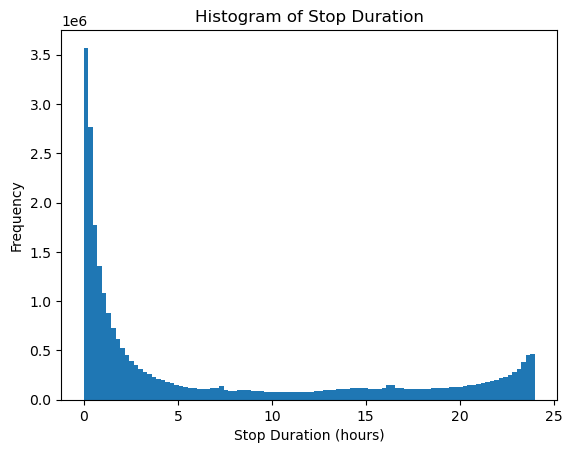

In [63]:
import matplotlib.pyplot as plt

# Assuming the DataFrame 'df' with a 'stop_duration' column

# Convert stop duration to hours for plotting
stop_duration_hours = df['stop_duration'] / pd.Timedelta(hours=1)

# Create histogram
plt.hist(stop_duration_hours, bins=100)  # Adjust the number of bins as desired
plt.xlabel('Stop Duration (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Stop Duration')
plt.show()


In [64]:
df.to_parquet(datadir+'wa_ldv_trips_with_county_and_dwell_time_fixed.parquet')

In [50]:
df.shape

(99892, 70)